#DESAFÍO Nro. 6 NLP: bot de preguntas y respuestas en inglés utilizando arquitectura encoder-decoder con LSTM y embeddings.

Las modificaciones realizadas en relación con el ejercicio original fueron:

* Se trata de resolver otro tipo de problema (objetivo del tp).
* Se utiliza otro dataset.
* Se utilizan embeddings FastText, tanto para el encoder, como para el decoder.
* Se prueba dos modelos: con y sin regularización.
* Se aumentan las epochs.
* Se agregan gráficos de la función de pérdida.
* Se comparan los modelos y se obtienen las conclusiones.


By Anahi Bazet

# Objetivo

Se construirá un BOT en inglés para responder a preguntas del usuario (QA).

## 1 - Librerías

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import re
import numpy as np
import json
import pandas as pd

from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.layers import Bidirectional
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

import logging
import os
from pathlib import Path
import pickle
import gdown

import matplotlib.pyplot as plt
import seaborn as sns

## 2 - Obtención de datos

Se utilizarán datos disponibles de convai sobre conversaciones en inglés: http://convai.io/data/

In [ ]:
# Descargar la carpeta del dataset.
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 176MB/s]


In [ ]:
# Cargar el dataset.
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

In [ ]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
#Armar la entrada del encoder, la salida del decoder y la entrada del decoder.
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>.
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>.
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [ ]:
#Entrada del encoder, salida del decoder, entrada del decoder.
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

## 3 - Preprocesamiento

In [ ]:
# Definir el tamaño máximo del vocabulario (limitación por la RAM).
MAX_VOCAB_SIZE = 8000

Primero se tokeniza la entrada del encoder.

In [ ]:
# Tokenizar las palabras con el Tokenizer de Keras.
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


Segundo se tokeniza la entrada y salida del decoder.

In [ ]:
# Sacamos los "<>" para que no afectar nuestros tokens especiales.
# Nuestros símbolos EOS y SOS tienen <>.
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
# Se suma 1 por el token especial.
print ("Palabras de salida:",num_words_output)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Palabras de salida: 1807
Sentencia de salida más larga: 10


Tercero se aplica padding a la entrada del encoder y la entrada del decoder.

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [ ]:
# También recorta si se pasa del tamaño máximo.
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


Cuarto y último, se aplica padding a la salida del decoder y se transforma a OHE.

La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategía que se transformó la entrada del decoder.

In [ ]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_targets shape:",decoder_targets.shape)

decoder_targets shape: (6033, 10, 1807)


## 4 - Preparar los embeddings

In [ ]:
# Se utilizan embeddings FastText.
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:51<00:00, 56.0MB/s]


In [ ]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # Build the vocabulary hashmap.
        index = np.arange(self.embeddings.shape[0])
        # Diccionarios para traducir de embedding a IDX de la palabra.
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
# Se utiliza FastText.
model_embeddings = FasttextEmbeddings()

In [ ]:
# Crear la Embedding matrix de las secuencias de entrada del encoder en inglés.

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)


#print (words_not_found)
print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [ ]:
# Dimensión de los embeddings de la secuencia de entrada del encoder en ingles
embedding_matrix.shape

(1799, 300)

In [ ]:
# Crear la Embedding matrix de las secuencias de entrada del decoder en inglés.

print('preparing embedding matrix...')
embed_dim_dec = model_embeddings.N_FEATURES
words_not_found_dec = []

nb_words_dec = min(MAX_VOCAB_SIZE, len(word2idx_outputs)) # vocab_size
embedding_matrix_dec = np.zeros((nb_words_dec, embed_dim_dec))
for word, i in word2idx_outputs.items():
    if i >= nb_words_dec:
        continue
    embedding_vector_dec = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector_dec is not None) and len(embedding_vector_dec) > 0:
        
        embedding_matrix_dec[i] = embedding_vector_dec
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found_dec.append(word)


#print (words_not_found_dec)
print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [ ]:
# Dimensión de los embeddings de la secuencia de entrada del decoder en ingles
embedding_matrix_dec.shape

(1806, 300)

## A - Sin regularización

### 5 - Entrenar el modelo

In [ ]:
n_units = 128

# Definir training encoder.
encoder_inputs = Input(shape=(max_input_len))
# max_input_len: 9

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Definir training decoder.
decoder_inputs = Input(shape=(max_out_len))
# max_out_len: 10
decoder_embedding_layer = Embedding(
          input_dim=nb_words_dec,  # definido en el Tokenizador
          output_dim=embed_dim_dec,  # dimensión de los embeddings utilizados
          input_length=max_out_len, # máxima sentencia de salida.
          weights=[embedding_matrix_dec],  # matrix de embeddings.
          trainable=False)      # marcar como layer no entrenable
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Drop out
# dropout = Dropout(rate=0.2)
# decoder_outputs = dropout(decoder_outputs)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 9, 300)       539700      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 300)      541800      ['input_2[0][0]']                
                                                                                              

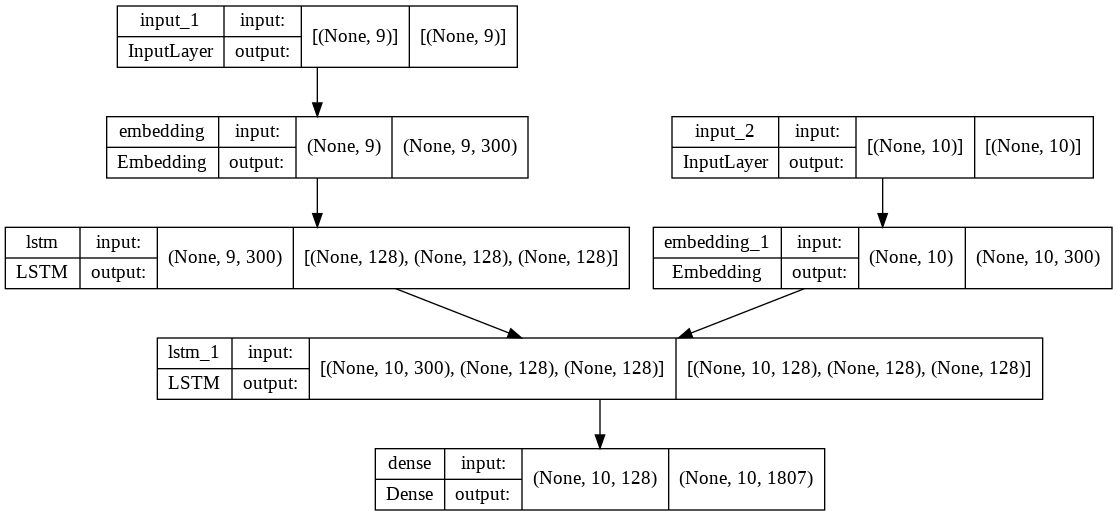

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

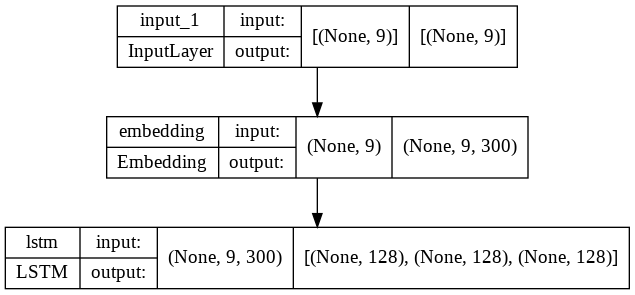

In [ ]:
# Definir inference encoder.
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

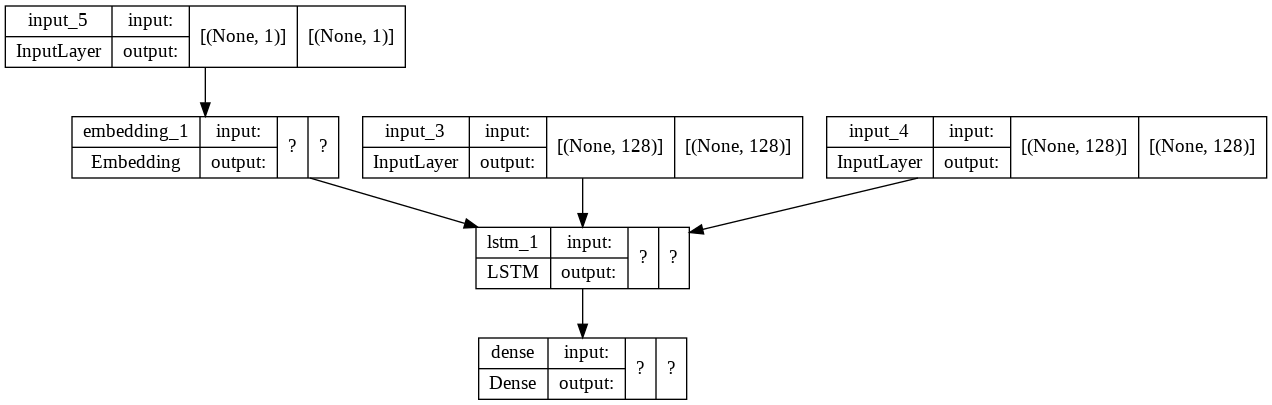

In [ ]:
# Definir inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# EN cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding.
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50, 
    validation_split=0.2)

Epoch 1/50
151/151 [==============================] - 12s 16ms/step - loss: 2.9851 - accuracy: 0.5344 - val_loss: 2.2611 - val_accuracy: 0.6289
Epoch 2/50
151/151 [==============================] - 1s 10ms/step - loss: 2.0021 - accuracy: 0.6482 - val_loss: 2.0424 - val_accuracy: 0.6674
Epoch 3/50
151/151 [==============================] - 2s 10ms/step - loss: 1.7835 - accuracy: 0.6893 - val_loss: 1.9319 - val_accuracy: 0.6795
Epoch 4/50
151/151 [==============================] - 2s 10ms/step - loss: 1.6687 - accuracy: 0.7016 - val_loss: 1.8806 - val_accuracy: 0.6837
Epoch 5/50
151/151 [==============================] - 2s 13ms/step - loss: 1.5983 - accuracy: 0.7083 - val_loss: 1.8506 - val_accuracy: 0.6880
Epoch 6/50
151/151 [==============================] - 2s 13ms/step - loss: 1.5438 - accuracy: 0.7158 - val_loss: 1.8253 - val_accuracy: 0.6925
Epoch 7/50
151/151 [==============================] - 2s 13ms/step - loss: 1.5010 - accuracy: 0.7203 - val_loss: 1.8054 - val_accuracy: 0.696

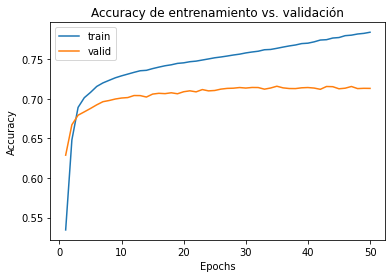

In [ ]:
# Métrica de entrenamiento vs. validación
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

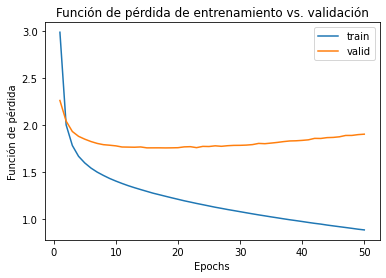

In [ ]:
# Función de pérdida de entrenamiento vs. validación
sns.lineplot(x=epoch_count, y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count, y=hist.history['val_loss'], label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.ylabel("Función de pérdida")
plt.xlabel("Epochs")
plt.show()

### 6 - Inferencia

In [ ]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # input_seq: tokenizada y con padding.
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder.
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>".
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el indice que finaliza la inferencia "<eos>".
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba.
        if eos == idx:
            break

        # Transformar idx a palabra.
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la ultima prediccion.
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentacion).
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
print (encoder_input_sequences.shape)
print (input_seq)
translation = translate_sentence(input_seq)
print('Input:', input_sentences[i])
print('Response:', translation)

(6033, 9)
[[  0   0   0   0   0   0 117 792   2]]
Input: who made you
Response: i am a girl


In [ ]:
input_test = "Do you read?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation_2 = translate_sentence(encoder_sequence_test)
print('Response:', translation_2)

Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  3  2 23]]
Input: Do you read?
Response: i do not know what to say


In [ ]:
input_test = "Do you have any pet?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test)
translation_3 = translate_sentence(encoder_sequence_test)
print('Response:', translation_3)

Input: Do you have any pet?
Response: no


In [ ]:
input_test = "Where are you from?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test)
translation_4 = translate_sentence(encoder_sequence_test)
print('Response:', translation_4)

Input: Where are you from?
Response: i m in cali


In [ ]:
input_test = "Do you like meat?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test)
translation_5 = translate_sentence(encoder_sequence_test)
print('Response:', translation_5)

Input: Do you like meat?
Response: i like to play video games


## B - Con regularización

### 5 - Entrenar el modelo

In [ ]:
n_units = 128

# Definir training encoder.
encoder_inputs = Input(shape=(max_input_len))
# max_input_len: 9

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Definir training decoder.
decoder_inputs = Input(shape=(max_out_len))
# max_out_len: 10
decoder_embedding_layer = Embedding(
          input_dim=nb_words_dec,  # definido en el Tokenizador
          output_dim=embed_dim_dec,  # dimensión de los embeddings utilizados
          input_length=max_out_len, # máxima sentencia de salida.
          weights=[embedding_matrix_dec],  # matrix de embeddings.
          trainable=False)      # marcar como layer no entrenable
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Drop out
dropout = Dropout(rate=0.2)
decoder_outputs = dropout(decoder_outputs)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 9, 300)       539700      ['input_6[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 10, 300)      541800      ['input_7[0][0]']                
                                                                                            

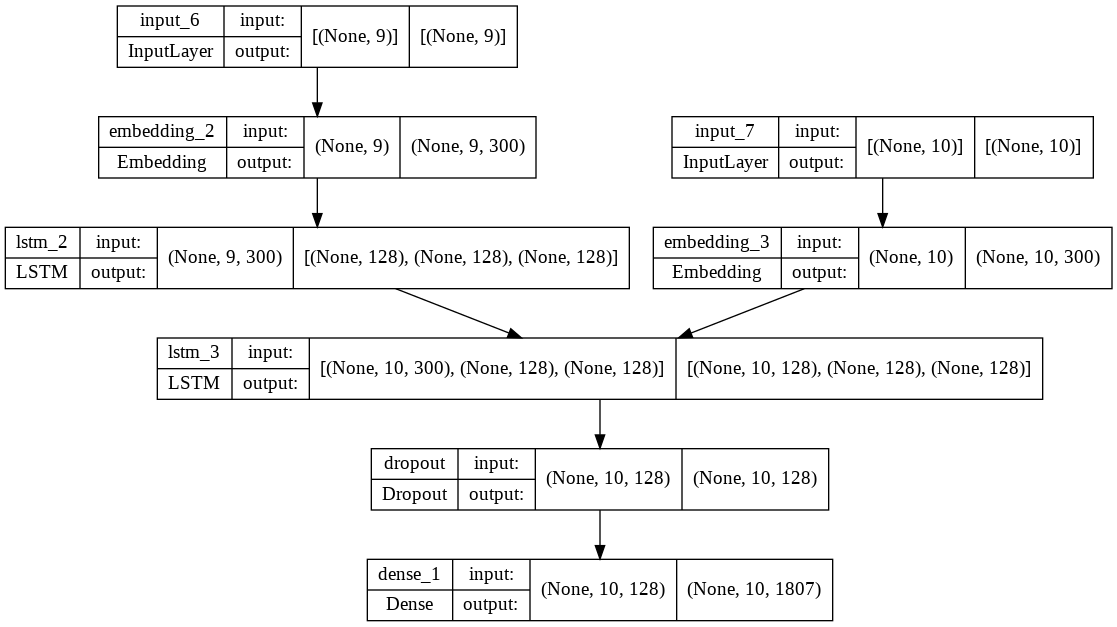

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

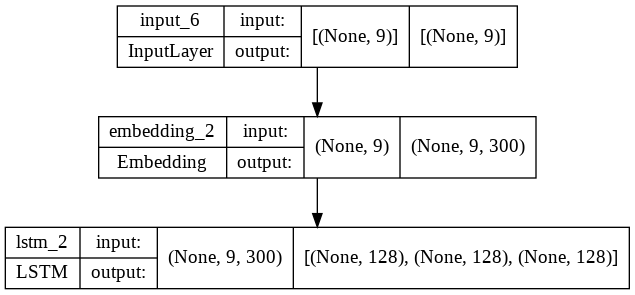

In [ ]:
# Definir inference encoder.
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

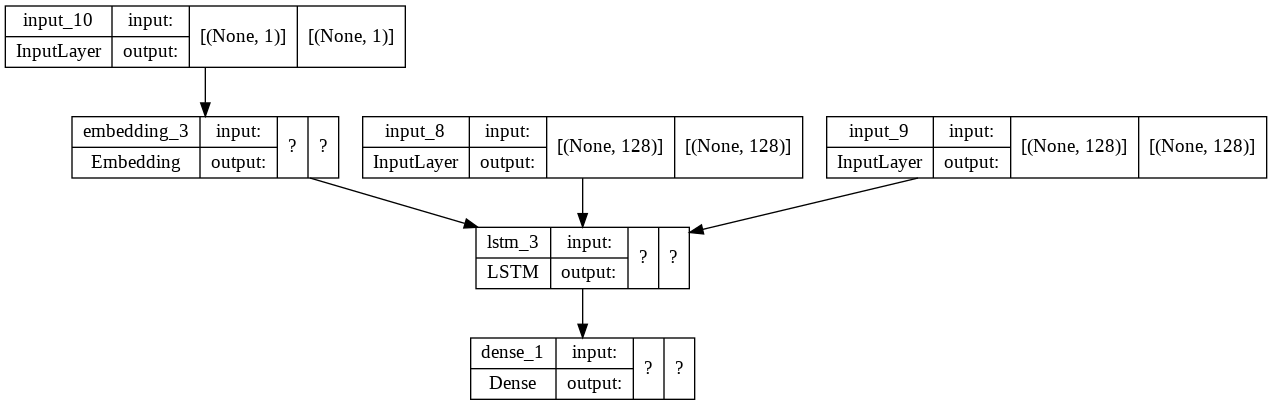

In [ ]:
# Definir inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# EN cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding.
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist_2 = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50, 
    validation_split=0.2)

Epoch 1/50
151/151 [==============================] - 5s 15ms/step - loss: 2.9488 - accuracy: 0.5383 - val_loss: 2.2354 - val_accuracy: 0.6314
Epoch 2/50
151/151 [==============================] - 2s 10ms/step - loss: 2.0234 - accuracy: 0.6446 - val_loss: 2.0468 - val_accuracy: 0.6663
Epoch 3/50
151/151 [==============================] - 1s 10ms/step - loss: 1.8175 - accuracy: 0.6827 - val_loss: 1.9424 - val_accuracy: 0.6793
Epoch 4/50
151/151 [==============================] - 2s 10ms/step - loss: 1.7007 - accuracy: 0.6979 - val_loss: 1.8899 - val_accuracy: 0.6825
Epoch 5/50
151/151 [==============================] - 2s 10ms/step - loss: 1.6279 - accuracy: 0.7063 - val_loss: 1.8558 - val_accuracy: 0.6901
Epoch 6/50
151/151 [==============================] - 1s 10ms/step - loss: 1.5755 - accuracy: 0.7128 - val_loss: 1.8338 - val_accuracy: 0.6933
Epoch 7/50
151/151 [==============================] - 2s 10ms/step - loss: 1.5349 - accuracy: 0.7160 - val_loss: 1.8176 - val_accuracy: 0.6957

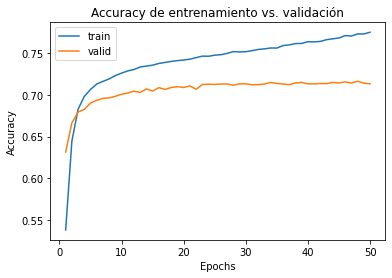

In [ ]:
# Métrica de entrenamiento vs. validación
epoch_count = range(1, len(hist_2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist_2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count, y=hist_2.history['val_accuracy'], label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

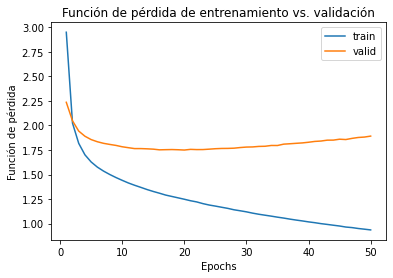

In [ ]:
# Función de pérdida de entrenamiento vs. validación
sns.lineplot(x=epoch_count, y=hist_2.history['loss'], label='train')
sns.lineplot(x=epoch_count, y=hist_2.history['val_loss'], label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.ylabel("Función de pérdida")
plt.xlabel("Epochs")
plt.show()

### 6 - Inferencia

In [ ]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # input_seq: tokenizada y con padding.
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder.
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>".
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el indice que finaliza la inferencia "<eos>".
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba.
        if eos == idx:
            break

        # Transformar idx a palabra.
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la ultima prediccion.
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentacion).
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
print (encoder_input_sequences.shape)
print (input_seq)
translation = translate_sentence(input_seq)
print('Input:', input_sentences[i])
print('Response:', translation)

(6033, 9)
[[   0    0    0    0    0    0    0    0 1489]]
Input: hahahaha
Response: hello how are you


In [ ]:
input_test_1 = "Do you read?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test_1])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test_1)
translation_6 = translate_sentence(encoder_sequence_test)
print('Response:', translation_6)

Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  3  2 23]]
Input: Do you read?
Response: i like to read


In [ ]:
input_test_2 = "Do you have any pet?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test_2])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test_2)
translation_7 = translate_sentence(encoder_sequence_test)
print('Response:', translation_7)

Input: Do you have any pet?
Response: no


In [ ]:
input_test_3 = "Where are you from?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test_3])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test_3)
translation_8 = translate_sentence(encoder_sequence_test)
print('Response:', translation_8)

Input: Where are you from?
Response: i am from the united states


In [ ]:
input_test_4 = "Do you like meat?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test_4])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test_4)
translation_9 = translate_sentence(encoder_sequence_test)
print('Response:', translation_9)

Input: Do you like meat?
Response: i like to play video games


## 7 - Conclusiones

### Gráfico de comparación de accuracy

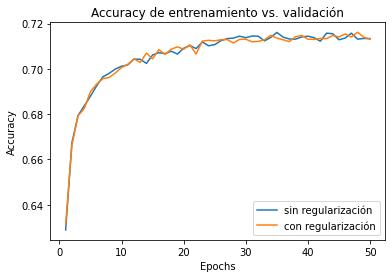

In [ ]:
# Métrica de validación con y sin regularización
epoch_count = range(1, len(hist_2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='sin regularización')
sns.lineplot(x=epoch_count, y=hist_2.history['val_accuracy'], label='con regularización')
plt.title("Accuracy de entrenamiento vs. validación")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

### Tabla de comparación de inferencia

In [ ]:
table_show = [ [input_test_1, translation_2, translation_6],
                 [input_test_2, translation_3, translation_7],
                 [input_test_3, translation_4, translation_8],
                 [input_test_4, translation_5, translation_9],]
dataframe_conclusion = pd.DataFrame(table_show, columns = ['Question','Answer sin reg','Answer con reg'])
print(dataframe_conclusion)

               Question              Answer sin reg  \
0          Do you read?   i do not know what to say   
1  Do you have any pet?                          no   
2   Where are you from?                 i m in cali   
3     Do you like meat?  i like to play video games   

                Answer con reg  
0               i like to read  
1                           no  
2  i am from the united states  
3   i like to play video games  


### Análisis de resultados

Si bien la métrica de accuracy en la validación es muy parecida en ambos modelos, la respuesta a las diferentes preguntas del ensayo es mucho mejor cuando se aplica regularización. A modo de ejemplo observar en la tabla que, a la pregunta "Do you read?", ambos modelos responden coherentemente, pero pareciera que el modelo con regularización tiene un comportamiento más humano respondiendo "I like to read", en vez de "I dont know what to say". Otro ejemplo lo podemos encontrar en la pregunta "Where are you from?", en donde se responde "I m in Cali" contra "I am from the united states". Esta última oración del modelo con regularización, tiene una mejor estructura semántica y es una posible respuesta correcta a la pregunta formulada.

